# ENEXIS Graduation Project

- Feature selection using lasso
- Try different models using these features

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, RidgeCV, LinearRegression 
from sklearn.metrics import r2_score
from sklearn import metrics, set_config
set_config(display="diagram")
warnings.filterwarnings(action="ignore", message="^internal gelsd")
TEST_SIZE = 0.2
RANDOM_STATE = 123

Reading of PV installed capacity & demographics dataset

In [4]:
c_path = "../Data/"
v_file = "PV installed capacity & demographics-n7"

In [5]:
df_orig = pd.read_csv(filepath_or_buffer = c_path + v_file + ".csv", encoding= 'UTF-8')

FileNotFoundError: [Errno 2] No such file or directory: './Data/PV installed capacity & demographics.csv'

In [ ]:
df_orig = df_orig[df_orig['Year'] == 2019]

In [ ]:
df_orig  = df_orig.drop('Year', axis = 1)

In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760 entries, 3 to 10857
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   BU_2021                                    1760 non-null   object 
 1   BU_NAAM                                    1760 non-null   object 
 2   WK_2021                                    1760 non-null   object 
 3   WK_NAAM                                    1760 non-null   object 
 4   GM_2021                                    1760 non-null   object 
 5   GM_NAAM                                    1760 non-null   object 
 6   ProvinciecodePV                            1760 non-null   object 
 7   Provincienaam                              1760 non-null   object 
 8   Aantal aansluitingen met opwekinstallatie  1760 non-null   float64
 9   Opgesteld vermogen                         1760 non-null   float64
 10  MeestVoorkomendePostcod

In [ ]:
df = df_orig

#### Data understanding - correlation matrix

In [ ]:
corr_matrix = df.corr().sort_values(by = 'Opgesteld_vermogen_per100houshoudens', ascending = False).transpose()
corr_matrix = corr_matrix.sort_values(by = 'Opgesteld_vermogen_per100houshoudens', ascending = False)

<AxesSubplot:>

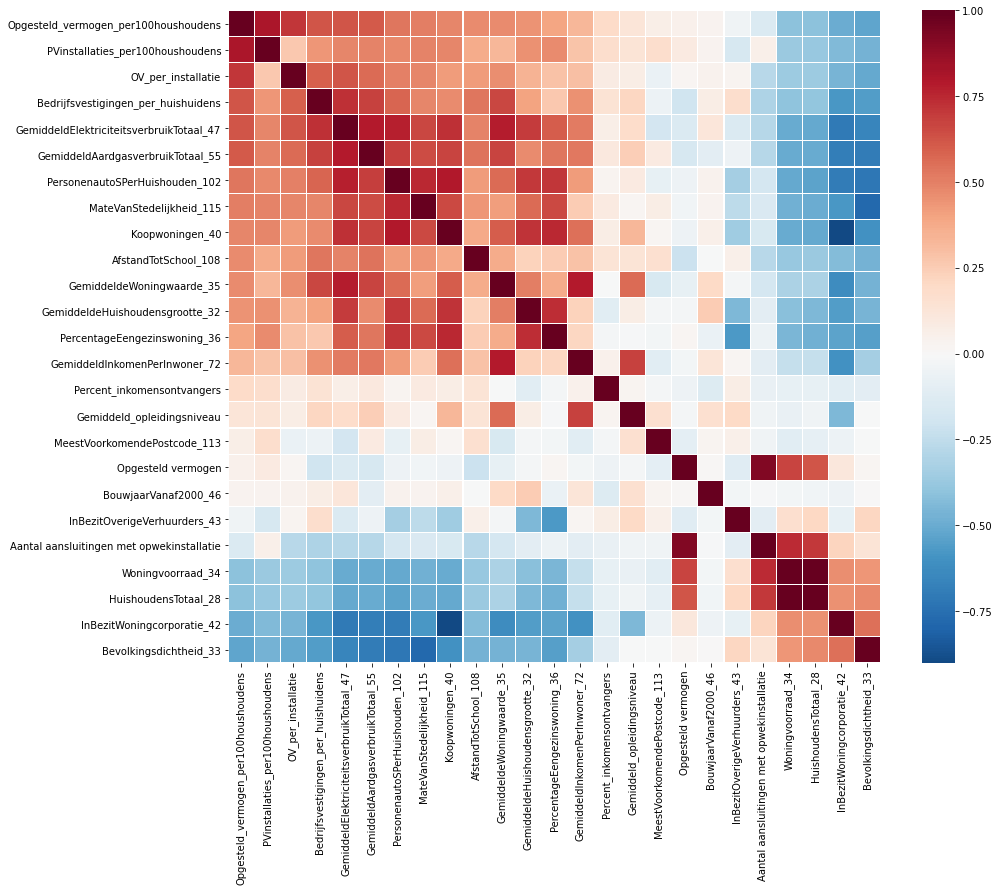

In [ ]:
plt.figure(figsize = (15,12))
sns.heatmap(data = corr_matrix, annot = False, fmt='.2f', cmap = 'RdBu_r', linewidths=.1, square=True, vmax=1, center = 0)

<a id='readpv'></a>
### Feature selection for modeling

In [ ]:
all_columns = ['HuishoudensTotaal_28', 'GemiddeldeHuishoudensgrootte_32',
       'Bevolkingsdichtheid_33', 'Woningvoorraad_34',
       'GemiddeldeWoningwaarde_35', 'PercentageEengezinswoning_36',
       'Koopwoningen_40', 'InBezitWoningcorporatie_42',
       'InBezitOverigeVerhuurders_43', 'BouwjaarVanaf2000_46',
       'GemiddeldElektriciteitsverbruikTotaal_47',
       'GemiddeldAardgasverbruikTotaal_55', 'Gemiddeld_opleidingsniveau',
       'Percent_inkomensontvangers', 'GemiddeldInkomenPerInwoner_72',
       'Bedrijfsvestigingen_per_huishuidens', 'PersonenautoSPerHuishouden_102',
       'AfstandTotSchool_108', 'MateVanStedelijkheid_115']

In [ ]:
categorical_features = ['GM_NAAM', 'Provincienaam']

In [ ]:
numeric_features = ['HuishoudensTotaal_28', 'GemiddeldeHuishoudensgrootte_32',
       'Bevolkingsdichtheid_33', 'Woningvoorraad_34',
       'GemiddeldeWoningwaarde_35', 'PercentageEengezinswoning_36',
       'Koopwoningen_40', 'InBezitWoningcorporatie_42',
       'InBezitOverigeVerhuurders_43', 'BouwjaarVanaf2000_46',
       'GemiddeldElektriciteitsverbruikTotaal_47',
       'GemiddeldAardgasverbruikTotaal_55', 'Gemiddeld_opleidingsniveau',
       'Percent_inkomensontvangers', 'GemiddeldInkomenPerInwoner_72',
       'Bedrijfsvestigingen_per_huishuidens', 'PersonenautoSPerHuishouden_102',
       'AfstandTotSchool_108', 'MateVanStedelijkheid_115']

In [ ]:
df = pd.merge(df[categorical_features], df[numeric_features], left_index=True, right_index=True)
df = df.join(df_orig['Opgesteld_vermogen_per100houshoudens'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760 entries, 3 to 10857
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   GM_NAAM                                   1760 non-null   object 
 1   Provincienaam                             1760 non-null   object 
 2   HuishoudensTotaal_28                      1760 non-null   int64  
 3   GemiddeldeHuishoudensgrootte_32           1760 non-null   float64
 4   Bevolkingsdichtheid_33                    1760 non-null   float64
 5   Woningvoorraad_34                         1760 non-null   int64  
 6   GemiddeldeWoningwaarde_35                 1644 non-null   float64
 7   PercentageEengezinswoning_36              1760 non-null   float64
 8   Koopwoningen_40                           1760 non-null   float64
 9   InBezitWoningcorporatie_42                1760 non-null   float64
 10  InBezitOverigeVerhuurders_43       

In [ ]:
y = df['Opgesteld_vermogen_per100houshoudens']
X = df.drop('Opgesteld_vermogen_per100houshoudens', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Setup the pipeline

In [ ]:
# Applying SimpleImputer and StandardScaler

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [ ]:
# Applying SimpleImputer and then OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## Model using: Linear regression

In [ ]:
lr = LinearRegression()

In [ ]:
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', lr)])

In [ ]:
model_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'GemiddeldeWoningwaarde_35',
                                                   'PercentageEengezinswoning_36',
                                                   'Koopwoningen_40',
                                                   'InBezit...
                                                   'GemiddeldInkomenPerInwoner_72',
                                                   'Bedrijfsvestigingen_per_huishuidens',
                                                   'PersonenautoSPerHuishouden_102',
                                                   'AfstandTotSchool_108',
                                                   'MateVanStedelijkheid_115']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GM_NAAM',
                                                   'Provincienaam'])])),
                ('estimator', LinearRegression())])

In [ ]:
y_pred = model_lr.predict(X_test)

In [ ]:
print(f"Mean absolute error:     {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared root error: {metrics.mean_squared_error(y_test, y_pred, squared=False)}") 
print(f"R2 score:                {metrics.r2_score(y_test, y_pred)}")

Mean absolute error:     34.11615982626062
Mean squared root error: 57.53423991677557
R2 score:                0.5865759199463702


In [ ]:
#coefs_LR_surv = pd.DataFrame(data = lr.coef_, index=df.columns, columns = ['Coef']).sort_values(by = 'Coef')
#coefs_LR_surv

In [ ]:
#plt.figure(figsize=(10,6))
#sns.barplot(data = coefs_LR_surv, x = coefs_LR_surv.index, y = 'Coef', color = 'navy' )
#plt.xticks(rotation = 90)
#plt.show()

## Model using: Support Vector machine

In [ ]:
from sklearn.svm import SVR

In [ ]:
svm_regression = SVR(gamma='auto')

In [ ]:
model_svr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', svm_regression)])

In [ ]:
model_svr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'GemiddeldeWoningwaarde_35',
                                                   'PercentageEengezinswoning_36',
                                                   'Koopwoningen_40',
                                                   'InBezit...
                                                   'GemiddeldInkomenPerInwoner_72',
                                                   'Bedrijfsvestigingen_per_huishuidens',
                                                   'PersonenautoSPerHuishouden_102',
                                                   'AfstandTotSchool_108',
                                                   'MateVanStedelijkheid_115']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GM_NAAM',
                                                   'Provincienaam'])])),
                ('estimator', SVR(gamma='auto'))])

In [ ]:
y_pred = model_svr.predict(X_test)

In [ ]:
print(f"Mean absolute error:     {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared root error: {metrics.mean_squared_error(y_test, y_pred, squared=False)}") 
print(f"R2 score:                {metrics.r2_score(y_test, y_pred)}")

Mean absolute error:     39.69715105806851
Mean squared root error: 76.56643353286613
R2 score:                0.26781665645774255


## Model using: Lasso  / Ridge

In [ ]:
lasso = LassoCV(
    #alphas       = [0.01, 0.02, 0.03, 0.1, 0.5, 1, 3, 5],
    eps          = 0.001,
    n_alphas     = 10,
    cv           = 5,
    random_state = RANDOM_STATE,
    n_jobs       = -1,
    max_iter     = 10000
    )

In [ ]:
#lasso = RidgeCV()

In [ ]:
model_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', lasso)])

In [ ]:
model_lasso.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'GemiddeldeWoningwaarde_35',
                                                   'PercentageEengezinswoning_36',
                                                   'Koopwoningen_40',
                                                   'InBezit...
                                                   'Bedrijfsvestigingen_per_huishuidens',
                                                   'PersonenautoSPerHuishouden_102',
                                                   'AfstandTotSchool_108',
                                                   'MateVanStedelijkheid_115']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GM_NAAM',
                                                   'Provincienaam'])])),
                ('estimator',
                 LassoCV(cv=5, max_iter=10000, n_alphas=10, n_jobs=-1,
                         random_state=123))])

In [ ]:
y_pred = model_lasso.predict(X_test)

In [ ]:
print(f"Mean absolute error:     {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared root error: {metrics.mean_squared_error(y_test, y_pred, squared=False)}") 
print(f"R2 score:                {metrics.r2_score(y_test, y_pred)}")

Mean absolute error:     33.49358327161288
Mean squared root error: 57.90080348329548
R2 score:                0.5812911026637394


## Model using: Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
GBRegressor = GradientBoostingRegressor()

In [ ]:
model_gb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', GBRegressor)])

In [ ]:
model_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'GemiddeldeWoningwaarde_35',
                                                   'PercentageEengezinswoning_36',
                                                   'Koopwoningen_40',
                                                   'InBezit...
                                                   'GemiddeldInkomenPerInwoner_72',
                                                   'Bedrijfsvestigingen_per_huishuidens',
                                                   'PersonenautoSPerHuishouden_102',
                                                   'AfstandTotSchool_108',
                                                   'MateVanStedelijkheid_115']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GM_NAAM',
                                                   'Provincienaam'])])),
                ('estimator', GradientBoostingRegressor())])

In [ ]:
y_pred = model_gb.predict(X_test)

In [ ]:
print(f"Mean absolute error:     {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared root error: {metrics.mean_squared_error(y_test, y_pred, squared=False)}") 
print(f"R2 score:                {metrics.r2_score(y_test, y_pred)}")

Mean absolute error:     32.42591340919149
Mean squared root error: 54.73139325475927
R2 score:                0.6258756147582089


## Model using: Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
decision_tree_regressor = DecisionTreeRegressor(max_depth = 3)

In [ ]:
model_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', decision_tree_regressor)])

In [ ]:
model_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'GemiddeldeWoningwaarde_35',
                                                   'PercentageEengezinswoning_36',
                                                   'Koopwoningen_40',
                                                   'InBezit...
                                                   'GemiddeldInkomenPerInwoner_72',
                                                   'Bedrijfsvestigingen_per_huishuidens',
                                                   'PersonenautoSPerHuishouden_102',
                                                   'AfstandTotSchool_108',
                                                   'MateVanStedelijkheid_115']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GM_NAAM',
                                                   'Provincienaam'])])),
                ('estimator', DecisionTreeRegressor(max_depth=3))])

In [ ]:
y_pred = model_dt.predict(X_test)

In [ ]:
print(f"Mean absolute error:     {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared root error: {metrics.mean_squared_error(y_test, y_pred, squared=False)}") 
print(f"R2 score:                {metrics.r2_score(y_test, y_pred)}")

Mean absolute error:     36.976217257969346
Mean squared root error: 60.387590976559366
R2 score:                0.5445523996552935


## Model using: K nearest neighbours (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
nearest_neighbour_regressor = KNeighborsRegressor(n_neighbors=5)

In [ ]:
model_knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', nearest_neighbour_regressor)])

In [ ]:
model_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'GemiddeldeWoningwaarde_35',
                                                   'PercentageEengezinswoning_36',
                                                   'Koopwoningen_40',
                                                   'InBezit...
                                                   'GemiddeldInkomenPerInwoner_72',
                                                   'Bedrijfsvestigingen_per_huishuidens',
                                                   'PersonenautoSPerHuishouden_102',
                                                   'AfstandTotSchool_108',
                                                   'MateVanStedelijkheid_115']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GM_NAAM',
                                                   'Provincienaam'])])),
                ('estimator', KNeighborsRegressor())])

In [ ]:
y_pred = model_knn.predict(X_test)

In [ ]:
print(f"Mean absolute error:     {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared root error: {metrics.mean_squared_error(y_test, y_pred, squared=False)}") 
print(f"R2 score:                {metrics.r2_score(y_test, y_pred)}")

Mean absolute error:     32.49554536035594
Mean squared root error: 58.81343496206357
R2 score:                0.5679877135573903


## Model using: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_regressor = RandomForestRegressor()

In [ ]:
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', rf_regressor)])

In [ ]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'GemiddeldeWoningwaarde_35',
                                                   'PercentageEengezinswoning_36',
                                                   'Koopwoningen_40',
                                                   'InBezit...
                                                   'GemiddeldInkomenPerInwoner_72',
                                                   'Bedrijfsvestigingen_per_huishuidens',
                                                   'PersonenautoSPerHuishouden_102',
                                                   'AfstandTotSchool_108',
                                                   'MateVanStedelijkheid_115']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GM_NAAM',
                                                   'Provincienaam'])])),
                ('estimator', RandomForestRegressor())])

In [ ]:
y_pred = model_rf.predict(X_test)

In [ ]:
y_pred_all = model_rf.predict(X)

In [ ]:
print(f"Mean absolute error:     {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared root error: {metrics.mean_squared_error(y_test, y_pred, squared=False)}") 
print(f"R2 score:                {metrics.r2_score(y_test, y_pred)}")

Mean absolute error:     32.07328042536159
Mean squared root error: 55.33133287417648
R2 score:                0.6176287130669129


In [ ]:
# Creating dataframe of predicted vs real values of y - test set

df1 = pd.DataFrame(y_test).reset_index(drop = True)
df2 = pd.DataFrame(y_pred, columns = ['y_pred']).reset_index(drop = True)
results = pd.concat([df1, df2], join = 'outer', ignore_index = True, axis = 1)
results.columns = ['y_test', 'y_pred']
results['diff_y'] = results['y_pred'] - results['y_test']
results['diff_y_rel'] = results['diff_y'] / results['y_pred']
results['diff_y_abs'] = abs(results['y_pred'] - results['y_test'])
results['diff_y_rel_abs'] = abs(results['diff_y'] / results['y_pred'])
results.head()

,y_test,y_pred,diff_y,diff_y_rel,diff_y_abs,diff_y_rel_abs
0,65.000000,61.291869,-3.708131,-0.060500,3.708131,0.060500
1,83.692308,80.162448,-3.529859,-0.044034,3.529859,0.044034
2,84.360902,84.729688,0.368786,0.004353,0.368786,0.004353
3,114.545455,117.467404,2.921949,0.024875,2.921949,0.024875
4,30.145773,33.778185,3.632412,0.107537,3.632412,0.107537


In [ ]:
# Creating dataframe of predicted vs real values of y - full dataset

df1 = pd.DataFrame(y).reset_index(drop = True)
df2 = pd.DataFrame(y_pred_all, columns = ['y_pred']).reset_index(drop = True)
results_full = pd.concat([df1, df2], join = 'outer', ignore_index = True, axis = 1)
results_full.columns = ['y_test', 'y_pred']
results_full['diff_y'] = results_full['y_pred'] - results_full['y_test']
results_full['diff_y_rel'] = results_full['diff_y'] / results_full['y_pred']
results_full['diff_y_abs'] = abs(results_full['y_pred'] - results_full['y_test'])
results_full['diff_y_rel_abs'] = abs(results_full['diff_y'] / results_full['y_pred'])
results_full.head()


,y_test,y_pred,diff_y,diff_y_rel,diff_y_abs,diff_y_rel_abs
0,108.120805,98.571813,-9.548992,-0.096873,9.548992,0.096873
1,353.846154,306.674060,-47.172094,-0.153818,47.172094,0.153818
2,92.897196,91.458676,-1.438520,-0.015729,1.438520,0.015729
3,181.111111,183.573162,2.462051,0.013412,2.462051,0.013412
4,82.758621,101.464314,18.705693,0.184357,18.705693,0.184357


In [ ]:
results.describe()

,y_test,y_pred,diff_y,diff_y_rel,diff_y_abs,diff_y_rel_abs
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,100.398311,98.013739,-2.384572,-0.018670,32.073280,0.319689
std,89.607894,68.379582,55.358616,0.439581,45.151442,0.301809
min,4.654731,6.160899,-494.365137,-2.315757,0.105680,0.002080
25%,47.083137,50.914034,-17.355573,-0.232012,7.055875,0.109898
50%,75.500858,81.169486,2.134214,0.046625,18.475620,0.240306
75%,125.838415,133.891873,20.693723,0.250567,40.129809,0.452177
max,772.000000,390.439179,181.005170,0.888316,494.365137,2.315757


In [ ]:
print(results['diff_y'].median())
print(results['diff_y_abs'].median())

2.1342142353947438
18.475619618799833


In [ ]:
print(results['diff_y_rel'].median())
print(results['diff_y_rel_abs'].median())

0.04662494443399172
0.24030642414430975


<AxesSubplot:>

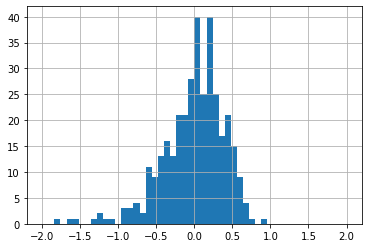

In [ ]:
results['diff_y_rel'].hist(bins = 50, range = [-2, 2])

<AxesSubplot:>

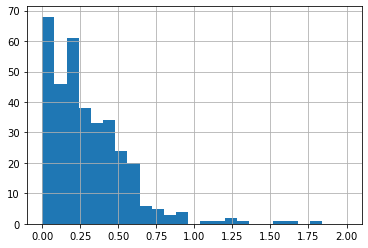

In [ ]:
results['diff_y_rel_abs'].hist(bins = 25, range = [0, 2])

Text(400, 500, 'r-squared = 0.618')

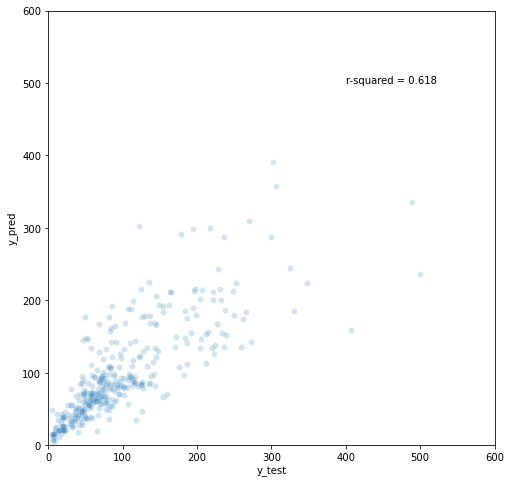

In [ ]:
plt.figure(figsize = (8,8))
ax = sns.scatterplot(data = results, x = 'y_test', y = 'y_pred', alpha = 0.2)
ax.set(xlim=(0,600),ylim=(0,600))
ax.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (400,500))

Text(400, 500, 'r-squared = 0.859')

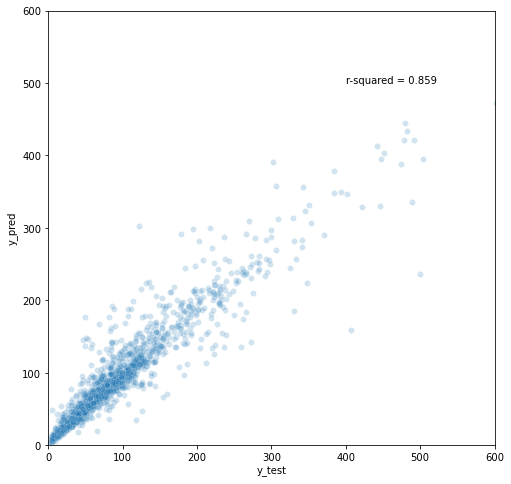

In [ ]:
plt.figure(figsize = (8,8))
ax = sns.scatterplot(data = results_full, x = 'y_test', y = 'y_pred', alpha = 0.2)
ax.set(xlim=(0,600),ylim=(0,600))
ax.annotate("r-squared = {:.3f}".format(r2_score(y, y_pred_all)), (400,500))

## Conclusion

The best models for the data and the selected features are:
- linear model
- lasso model
- KNN model (6 or 7 neighbours)

The decision tree and SVM model are not as good as the above mentioned ones.

The highest score is 0,43 for the linear model.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0604020-40e6-4d7d-a2ba-74ef2b385723' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>